# Notebook for preparing and saving TSP graphs

In [1]:
import numpy as np
import torch
import pickle
import time
import os
%matplotlib inline
import matplotlib.pyplot as plt

# Convert to DGL format and save with pickle

In [3]:
import os
os.chdir('../../') # go to root folder of the project
print(os.getcwd())


/home/cailtsptest/tsp/benchmarking-gnns


In [4]:
import pickle

%load_ext autoreload
%autoreload 2

from torch.utils.data import DataLoader

from data.data import LoadData
from data.tsp_dataset import TSP, TSPDatasetDGL, TSPDataset

In [5]:
start = time.time()

DATASET_NAME = 'TSP'
dataset = TSPDatasetDGL(DATASET_NAME) 

print('Time (sec):',time.time() - start)


preparing all graphs for the TRAIN set...
preparing all graphs for the VAL set...
preparing all graphs for the TEST set...
Time (sec): 4599.298296451569


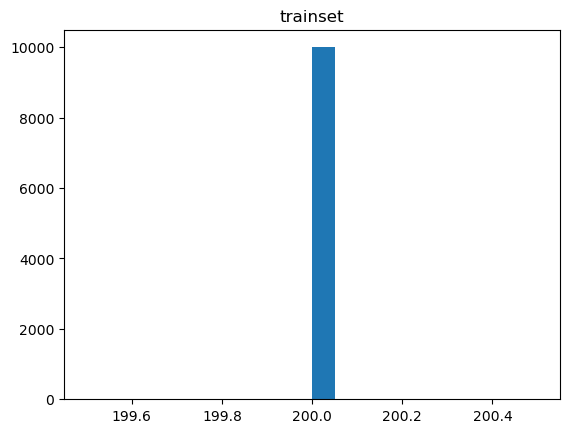

nb/min/max : 10000 200 200


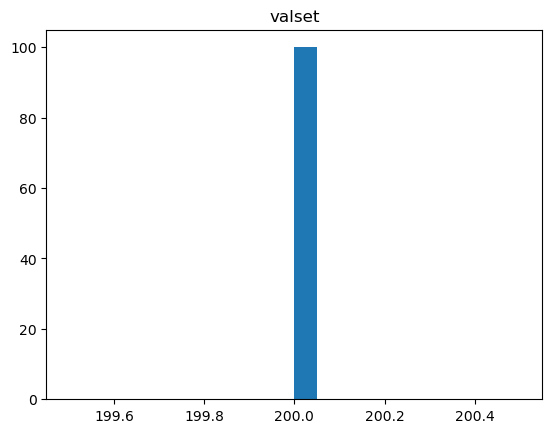

nb/min/max : 100 200 200


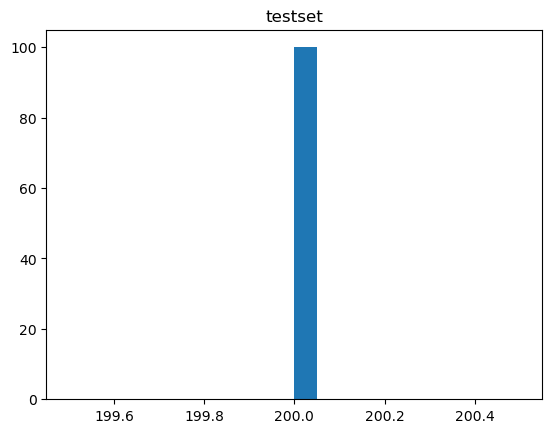

nb/min/max : 100 200 200


In [6]:
def plot_histo_graphs(dataset, title):
    # histogram of graph sizes
    graph_sizes = []
    for graph in dataset:
        graph_sizes.append(graph[0].number_of_nodes())
        #graph_sizes.append(graph[0].number_of_edges())
    plt.figure(1)
    plt.hist(graph_sizes, bins=20)
    plt.title(title)
    plt.show()
    graph_sizes = torch.Tensor(graph_sizes)
    print('nb/min/max :',len(graph_sizes),graph_sizes.min().long().item(),graph_sizes.max().long().item())
    
plot_histo_graphs(dataset.train,'trainset')
plot_histo_graphs(dataset.val,'valset')
plot_histo_graphs(dataset.test,'testset')


In [7]:
print(len(dataset.train))
print(len(dataset.val))
print(len(dataset.test))

print(dataset.train[0])
print(dataset.val[0])
print(dataset.test[0])


10000
100
100
(Graph(num_nodes=200, num_edges=39600,
      ndata_schemes={'feat': Scheme(shape=(2,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(6,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
start = time.time()

with open('data/TSP/TSP.pkl','wb') as f:
    pickle.dump([dataset.train,dataset.val,dataset.test],f)
        
print('Time (sec):',time.time() - start) # 58s


# Test load function

In [8]:
DATASET_NAME = 'TSP'
dataset = LoadData(DATASET_NAME)  # 20s
trainset, valset, testset = dataset.train, dataset.val, dataset.test


[I] Loading dataset TSP...
train, test, val sizes : 10000 100 100
[I] Finished loading.
[I] Data load time: 18.0915s


In [9]:
start = time.time()

batch_size = 10
collate = TSPDataset.collate
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate)

print('Time (sec):',time.time() - start)  # 0.0003s


Time (sec): 0.00014901161193847656


# Plot TSP samples

In [10]:
from scipy.spatial.distance import pdist, squareform
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx


def _edges_to_node_pairs(W):
    """Helper function to convert edge matrix into pairs of adjacent nodes.
    """
    pairs = []
    for r in range(len(W)):
        for c in range(len(W)):
            if W[r][c] == 1:
                pairs.append((r, c))
    return pairs

def plot_tsp(x_coord, W, tour):
    """
    Helper function to plot TSP tours.
    
    Args:
        x_coord: Coordinates of nodes
        W: Graph as adjacency matrix
        tour: Predicted tour
        title: Title of figure/subplot
    """
    W_val = squareform(pdist(x_coord, metric='euclidean'))
    G = nx.from_numpy_matrix(W_val)
    
    pos = dict(zip(range(len(x_coord)), x_coord))
    
    adj_pairs = _edges_to_node_pairs(W)
    
    tour_pairs = []
    for idx in range(len(tour)-1):
        tour_pairs.append((tour[idx], tour[idx+1]))
    tour_pairs.append((tour[idx+1], tour[0]))
    
    node_size = 50/(len(x_coord)//50)
    
    nx.draw_networkx_nodes(G, pos, node_color='b', node_size=node_size)
    nx.draw_networkx_edges(G, pos, edgelist=adj_pairs, alpha=0.25, width=0.1)
    nx.draw_networkx_edges(G, pos, edgelist=tour_pairs, alpha=1, width=1.5, edge_color='r')

In [15]:
filename = "data/TSP/tsp50-500_test.txt"
file_data = open(filename, "r").readlines()
num_neighbors = 25

In [17]:
for graph_idx, line in enumerate(file_data):
    line = line.split(" ")  # Split into list
    num_nodes = int(line.index('output')//2)

    # Convert node coordinates to required format
    nodes_coord = []
    for idx in range(0, 2 * num_nodes, 2):
        nodes_coord.append([float(line[idx]), float(line[idx + 1])])

    # Compute distance matrix
    W_val = squareform(pdist(nodes_coord, metric='euclidean'))
    # Determine k-nearest neighbors for each node
    knns = np.argpartition(W_val, kth=num_neighbors, axis=-1)[:, num_neighbors::-1]
    
    W = np.zeros((num_nodes, num_nodes))
    # Make connections 
    for idx in range(num_nodes):
        W[idx][knns[idx]] = 1

    # Convert tour nodes to required format
    # Don't add final connection for tour/cycle
    tour_nodes = [int(node) - 1 for node in line[line.index('output') + 1:-1]][:-1]

    # Compute an edge adjacency matrix representation of tour
    edges_target = np.zeros((num_nodes, num_nodes))
    for idx in range(len(tour_nodes) - 1):
        i = tour_nodes[idx]
        j = tour_nodes[idx + 1]
        edges_target[i][j] = 1
        edges_target[j][i] = 1
    # Add final connection of tour in edge target
    edges_target[j][tour_nodes[0]] = 1
    edges_target[tour_nodes[0]][j] = 1
    
    if num_nodes == 498:
        print(num_nodes)
        print(tour_nodes)

        plt.figure(figsize=(5,5))
        plot_tsp(nodes_coord, W, tour_nodes)
        plt.savefig(f"img/tsp{num_nodes}_{graph_idx}.pdf", format='pdf', dpi=1200, bbox_inches='tight')
        plt.show()
        print("Stop (y/n)")
        if input() == 'y':
            break